<a href="https://colab.research.google.com/github/suvosree/Homework/blob/main/LSTM_IMDB_Sentiment_Example_(me).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## What is this?

This Jupyter Notebook contains Python code for building a LSTM Recurrent Neural Network that gives 87-88% accuracy on the IMDB Movie Review Sentiment Analysis Dataset. 

More information is given on [this blogpost](https://www.bouvet.no/bouvet-deler/explaining-recurrent-neural-networks).

This code is supplied without license, warranty or support. Feel free to do with it what you will.

## Built for Google Collaboratory

Train your network more quickly in Google Collaboratory. From the **Runtime** menu select **Change Runtime** Type and choose "GPU"!

Don't forget to select **Runtime** -> **Restart runtime** to put your changes into effect.

## Setting up

When running this for the first time you may get a warning telling you to restart the Runtime. You can ignore this, but feel free to select "Runtime->Restart Runtime" from the overhead menu if you encounter problems.

In [81]:
# keras.datasets.imdb is broken in TensorFlow 1.13 and 1.14 due to numpy 1.16.3
#!pip install numpy==1.18.5

# All the imports!
import tensorflow as tf 
import numpy as np
from tensorflow.keras.preprocessing import sequence
from numpy import array
from keras.layers.recurrent import SimpleRNN
optimizer = tf.keras.optimizers.Adam()
import matplotlib.pyplot as plt


# Supress deprecation warnings
import logging
logging.getLogger('tensorflow').disabled = True

# Fetch "IMDB Movie Review" data, constraining our reviews to 
# the 10000 most commonly used words
vocab_size = 10000
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=vocab_size)

# Map for readable classnames
class_names = ["Negative", "Positive"]
print(tf.__version__)


2.7.0


## Create map for converting IMDB dataset to readable reviews

Reviews in the IMDB dataset have been encoded as a sequence of integers. Luckily the dataset also 
contains an index for converting the reviews back into human readable form.

In [82]:
# Get the word index from the dataset
word_index = tf.keras.datasets.imdb.get_word_index()

# Ensure that "special" words are mapped into human readable terms 
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNKNOWN>"] = 2
word_index["<UNUSED>"] = 3

# Perform reverse word lookup and make it callable
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

## Data Insight

Here we take a closer look at our data. How many words do our reviews contain?

And what do our review look like in machine and human readable form?


In [83]:
# Concatonate test and training datasets
allreviews = np.concatenate((x_train, x_test), axis=0)

# Review lengths across test and training whole datasets
print("Maximum review length: {}".format(len(max((allreviews), key=len))))
print("Minimum review length: {}".format(len(min((allreviews), key=len))))
result = [len(x) for x in allreviews]
print("Mean review length: {}".format(np.mean(result)))

# Print a review and it's class as stored in the dataset. Replace the number
# to select a different review.
print("")
print("Machine readable Review")
print("  Review Text: " + str(x_train[60]))
print("  Review Sentiment: " + str(y_train[60]))

# Print a review and it's class in human readable format. Replace the number
# to select a different review.
print("")
print("Human Readable Review")
print("  Review Text: " + decode_review(x_train[60]))
print("  Review Sentiment: " + class_names[y_train[60]])

Maximum review length: 2494
Minimum review length: 7
Mean review length: 234.75892

Machine readable Review
  Review Text: [1, 13, 219, 14, 33, 4, 2, 22, 1413, 12, 16, 373, 175, 2711, 1115, 1026, 430, 939, 16, 23, 2444, 25, 43, 697, 89, 12, 16, 170, 8, 130, 262, 19, 32, 4, 665, 7, 4, 2, 322, 5, 4, 1520, 7, 4, 86, 250, 10, 10, 4, 249, 173, 16, 4, 3891, 6, 19, 4, 167, 564, 5, 564, 1325, 36, 805, 8, 216, 638, 17, 2, 21, 25, 100, 376, 507, 4, 2110, 15, 79, 125, 23, 567, 13, 2134, 233, 36, 4852, 2, 5, 81, 1672, 10, 10, 92, 437, 129, 58, 13, 69, 8, 401, 61, 1432, 39, 1286, 46, 7, 12]
  Review Sentiment: 0

Human Readable Review
  Review Text: <START> i saw this at the <UNKNOWN> film festival it was awful every clichéd violent rich boy fantasy was on display you just knew how it was going to end especially with all the shots of the <UNKNOWN> wife and the rape of the first girl br br the worst part was the q a with the director writer and writer producer they tried to come across as <UNKNOWN> 

## Pre-processing Data

We need to make sure that our reviews are of a uniform length. This is for the LSTM's parameters.

Some reviews will need to be truncated, while others need to be padded.

In [84]:
# The length of reviews
review_length = 500

# Padding / truncated our reviews
x_train = sequence.pad_sequences(x_train, maxlen = review_length)
x_test = sequence.pad_sequences(x_test, maxlen = review_length)

# Check the size of our datasets. Review data for both test and training should 
# contain 25000 reviews of 500 integers. Class data should contain 25000 values, 
# one for each review. Class values are 0 or 1, indicating a negative 
# or positive review.
print("Shape Training Review Data: " + str(x_train.shape))
print("Shape Training Class Data: " + str(y_train.shape))
print("Shape Test Review Data: " + str(x_test.shape))
print("Shape Test Class Data: " + str(y_test.shape))

# Note padding is added to start of review, not the end
print("")
print("Human Readable Review Text (post padding): " + decode_review(x_train[60]))

Shape Training Review Data: (25000, 500)
Shape Training Class Data: (25000,)
Shape Test Review Data: (25000, 500)
Shape Test Class Data: (25000,)

Human Readable Review Text (post padding): <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

## Create and build LSTM Recurrent Neural Network

In [85]:

def make_model_withdropout(RNN_layer):
    model=tf.keras.models.Sequential()
    model.add(tf.keras.layers.Embedding(input_dim=vocab_size,output_dim=32,input_length=review_length))
    model.add(tf.keras.layers.Dropout(rate=0.25))
    model.add(RNN_layer(units=32))
    
    model.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))
    model.add(
    tf.keras.layers.Dropout(
        rate=0.25 # Randomly disable 25% of neurons
    )
)
    return model

RNN_layer=[tf.keras.layers.SimpleRNN,tf.keras.layers.LSTM,tf.keras.layers.GRU]

for i in range(0,(len(RNN_layer))):
    
    models_1=make_model_withdropout(RNN_layer[i])
    models_1.compile(
    loss=tf.keras.losses.binary_crossentropy, # loss function
    optimizer=tf.keras.optimizers.Adam(), # optimiser function
    metrics=['accuracy']) # reporting metric
    print(models_1.summary())
  

def make_model_withoutdropout(RNN_layer):
    model=tf.keras.models.Sequential()
    model.add(tf.keras.layers.Embedding(input_dim=vocab_size,output_dim=32,input_length=review_length))
    
    model.add(RNN_layer(units=32))
    
    model.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))
    

    return model

RNN_layer=[tf.keras.layers.SimpleRNN,tf.keras.layers.LSTM,tf.keras.layers.GRU]

for i in range(0,(len(RNN_layer))):
    
    models=make_model_withoutdropout(RNN_layer[i])
    models.compile(
    loss=tf.keras.losses.binary_crossentropy, # loss function
    optimizer=tf.keras.optimizers.Adam(), # optimiser function
    metrics=['accuracy']) # reporting metric
    print(models.summary())


def make_model_without_embedding(RNN_layer):
    model=tf.keras.models.Sequential()
    
    model.add(RNN_layer(units=32))
    model.add(
    tf.keras.layers.Dropout(
        rate=0.25 # Randomly disable 25% of neurons
    )
)
    model.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))
    

    return model

RNN_layer=[tf.keras.layers.SimpleRNN,tf.keras.layers.LSTM,tf.keras.layers.GRU]

for i in range(0,(len(RNN_layer))):
    
    models_2=make_model_withoutdropout(RNN_layer[i])
    models_2.compile(
    loss=tf.keras.losses.binary_crossentropy, # loss function
    optimizer=tf.keras.optimizers.Adam(), # optimiser function
    metrics=['accuracy']) # reporting metric
    print(models_2.summary())





Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_67 (Embedding)    (None, 500, 32)           320000    
                                                                 
 dropout_100 (Dropout)       (None, 500, 32)           0         
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_47 (Dense)            (None, 1)                 33        
                                                                 
 dropout_101 (Dropout)       (None, 1)                 0         
                                                                 
Total params: 322,113
Trainable params: 322,113
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_68"
___________________

## Visualise the Model

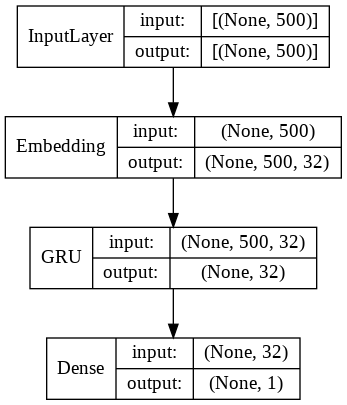

In [87]:
tf.keras.utils.plot_model(models, to_file='model.png', show_shapes=True, show_layer_names=False)
tf.keras.utils.plot_model(models_1, to_file='model.png', show_shapes=True, show_layer_names=False)
tf.keras.utils.plot_model(models_2, to_file='model.png', show_shapes=True, show_layer_names=False)

## Train the LSTM

Epoch 1/3
79/79 [==============================] - 9s 93ms/step - loss: 0.6394 - accuracy: 0.6295 - val_loss: 0.4397 - val_accuracy: 0.7954
Epoch 2/3
79/79 [==============================] - 6s 82ms/step - loss: 0.3274 - accuracy: 0.8637 - val_loss: 0.3295 - val_accuracy: 0.8594
Epoch 3/3
79/79 [==============================] - 6s 78ms/step - loss: 0.2273 - accuracy: 0.9154 - val_loss: 0.3201 - val_accuracy: 0.8690
--------------------------------------------------
Epoch 1/3
79/79 [==============================] - 10s 87ms/step - loss: 2.4203 - accuracy: 0.5669 - val_loss: 0.6518 - val_accuracy: 0.5860
Epoch 2/3
79/79 [==============================] - 6s 78ms/step - loss: 2.2461 - accuracy: 0.7007 - val_loss: 0.5051 - val_accuracy: 0.7550
Epoch 3/3
79/79 [==============================] - 6s 77ms/step - loss: 2.1996 - accuracy: 0.7644 - val_loss: 0.4434 - val_accuracy: 0.7976
--------------------------------------------------
Epoch 1/3
79/79 [==============================] - 9s 83m

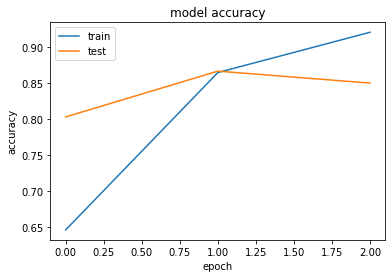

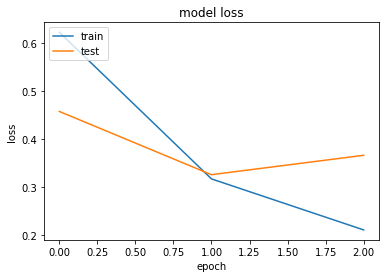

In [88]:
# Train the LSTM on the training data
hist=[models,models_1,models_2]
for i in range(len(hist)):
  history=hist[i].fit(

    # Training data : features (review) and classes (positive or negative)
    x_train, y_train,
                    
    # Number of samples to work through before updating the 
    # internal model parameters via back propagation. The 
    # higher the batch, the more memory you need.
    batch_size=256, 

    # An epoch is an iteration over the entire training data.
    epochs=3, 
    
    # The model will set apart his fraction of the training 
    # data, will not train on it, and will evaluate the loss
    # and any model metrics on this data at the end of 
    # each epoch.
    validation_split=0.2,
    
    verbose=1
) 
  print("--------------------------------------------------")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Evaluate model with test data and view results

In [89]:
# Get Model Predictions for test data
from sklearn.metrics import classification_report
predicted_classes = models.predict(x_test)

#predicted_classes = model.predict_classes(x_test)
#print(classification_report(y_test, predicted_classes, target_names=class_names))
predicted_classes_orig = predicted_classes

predicted_classes_01 = (predicted_classes >= 0.5).astype(np.int).reshape(predicted_classes_orig.shape)

print(classification_report(y_test, predicted_classes_01, target_names=class_names))

predicted_classes = predicted_classes_01

              precision    recall  f1-score   support

    Negative       0.86      0.87      0.87     12500
    Positive       0.87      0.86      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



## View some incorrect predictions

Lets have a look at some of the incorrectly classified reviews. For readability we remove the padding.



In [90]:
#print(predicted_classes.shape)
predicted_classes_reshaped = np.reshape(predicted_classes_01, 25000)
incorrect_all = np.nonzero(predicted_classes_reshaped!=y_test)[0]

print("test data prediction accuracy=", 1 - incorrect_all.shape[0] / predicted_classes.shape[0])

# We select the first 10 incorrectly classified reviews
for j, incorrect in enumerate(incorrect_all[0:20]):
    predicted = class_names[predicted_classes_reshaped[incorrect]]
    actual = class_names[y_test[incorrect]]
    human_readable_review = decode_review(x_test[incorrect])
    
    print("Incorrectly classified Test Review ["+ str(j+1) +"]") 
    print("Test Review #" + str(incorrect)  + ": Predicted ["+ predicted + "] Actual ["+ actual + "]")
    print("Test Review Text: " + human_readable_review.replace("<PAD> ", ""))
    print("")

test data prediction accuracy= 0.86464
Incorrectly classified Test Review [1]
Test Review #5: Predicted [Negative] Actual [Positive]
Test Review Text: <START> i'm absolutely disgusted this movie isn't being sold all who love this movie should email disney and increase the demand for it they'd eventually have to sell it then i'd buy copies for everybody i know everything and everybody in this movie did a good job and i haven't figured out why disney hasn't put this movie on dvd or on vhs in rental stores at least i haven't seen any copies this is a wicked good movie and should be seen by all the kids in the new generation don't get to see it and i think they should it should at least be put back on the channel this movie doesn't deserve a cheap <UNKNOWN> it deserves the real thing i'm them now this movie will be on dvd

Incorrectly classified Test Review [2]
Test Review #8: Predicted [Positive] Actual [Negative]
Test Review Text: <START> hollywood had a long love affair with bogus <UNKN

## Run your own text against the trained model

This is a fun way to test out the limits of the trained model. To avoid getting errors - type in lower case only and do not use punctuation! 

You'll see the raw prediction from the model - basically a value between 0 and 1.



In [91]:
# Write your own review
#review = "this was a terrible film with too much sex and violence i walked out halfway through"
review = "this was an awful film that i will never see again"

# Encode review (replace word with integers)
tmp = []
for word in review.split(" "):
    tmp.append(word_index[word])

# Ensure review is 500 words long (by padding or truncating)
tmp_padded = sequence.pad_sequences([tmp], maxlen=review_length) 

# Run your processed review against the trained model
rawprediction = model.predict(array([tmp_padded][0]))[0][0]
prediction = int(round(rawprediction))

# Test the model and print the result
print("Review: " + review)
print("Raw Prediction: " + str(rawprediction))
print("Predicted Class: " + class_names[prediction])

Review: this was an awful film that i will never see again
Raw Prediction: 0.50146604
Predicted Class: Positive
